In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Investigating cointegration in the US yield curve


In this notebook we will explore the cointegration relationship of two US government note yields. The US government issues notes and bonds to borrow money. These notes are established for a certain borrowing term. At the start of the term, Investors will pay the full value of the bond to the government. The government can then use the money as they see fit, meanwhile paying interest only to the investor. Once the borrowing term is completed, the government must pay back to full value (principal) of the bond.

In the meantime, these bonds can be traded back and forth (the original investor does not need to hold on to them). The current size of the US bond market is $46 trillion dollars and is considered the benchmark for the global market of bonds. All other bonds are priced in relation to the US government bonds. 

As these bonds are traded back and forth, the values can go up and down. Similarly the yields can go up and down. It is this moving yield that is typically reported by market news agencies. We can explore the relationship between two government bonds of particular length.

 - **2Y to 30Y curve** is popular and is watched for "steepness" or "flatness" as an indicator of growth and inflation in the economy. Typically, when the curve goes "inverted" this is major economic news and typically forecasts a recession. Fall 2019
 - **5Y to 10Y curve** represents the "belly" of the curve. Most of the volume will occur in these two more liquid points of the curve. They experience the most short term disequilibrium.
 - **10Y to 30Y** is the tail end of the curve. It represents 20 years of duration and has the most volatility.
 
This workshop explores the FIT spread (5Y to 10Y) yield curve




## Pulling Data

Here we pull data from the FRED website:https://fred.stlouisfed.org/
This site is an online database consisting of hundred of thousands of economic data time series. This data can be from national, international, public and private source. The database is maintained by the Research Department at the Federal Reserve Bank of St. Louis.

This database has grown organically from its beginings in the early 1990s. Not only can you access and download data, but you can visualize the data using their built in charts. User controls such as fonts, colors and line styles allow for custimization.

In [2]:
from fredapi import Fred

def get_data(api_key='fc3d944885af80bfd0a78cad14e331f4', fp=None):
    '''
    This function will pull data from FRED website, 
    either by using the api key, or by giving a csv file
    '''    
    if fp is None:
        fred = Fred(api_key=api_key)

        dsg1 = fred.get_series('DGS5')
        dsg3 = fred.get_series('DGS10')

        df = pd.concat([dsg1, dsg3], axis=1)
        df.columns = ['WGS5YR', 'WGS10YR']
        df.fillna(method='ffill', inplace=True)
        
    else:
        df = pd.read_csv(fp, index_col=0)
        df.index = pd.to_datetime( df.index )
        df.sort_index(inplace=True)
    return df

In [3]:
df = get_data()
#df(get_data=(fp='WGS5_10YR.csv')

<AxesSubplot:xlabel='WGS5YR', ylabel='WGS10YR'>

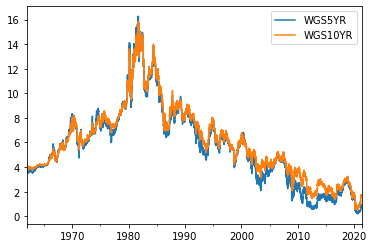

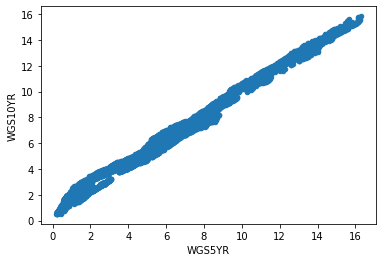

In [4]:
df.plot()
df.plot(kind='scatter', x='WGS5YR', y='WGS10YR')

## Describe the data

Here we see two dataset over 35 years that seem to be very related. 
- Is one consistently higher than the other?
- Are these data stationary?
- We also see a positive correlated relationship

## Create a Linear Regression Summary

In [5]:
from sklearn.linear_model import LinearRegression

lmod = LinearRegression()
lmod.fit(df[['WGS5YR']], df[['WGS10YR']])

LinearRegression()

Which is the predictor variable and which is the predicted variable?

In [6]:
print('coef: {} intercept: {}'.format( lmod.coef_, lmod.intercept_))

coef: [[0.9263564]] intercept: [0.75594753]


In [7]:
print('rsqr: {}'.format( lmod.score(df[['WGS5YR']], df[['WGS10YR']])))

rsqr: 0.9864707633821661


### What do we think about this r-squared?

In [8]:
# Create residuals y_pred - y_actuals
residuals = lmod.predict(df[['WGS5YR']]) - df[['WGS10YR']]

## Plot Residuals

<AxesSubplot:>

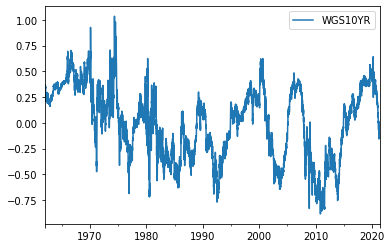

In [9]:
residuals.plot()

## Run Ljung Box

In [10]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

sm.stats.acorr_ljungbox(residuals, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,179910.462925,0.0


#### With a Ljung Box pvalue of 0, what can we say about our residuals? Do they resemble white noise?

## Plot ACF of Residuals

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

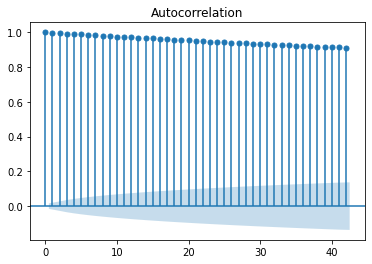

In [12]:
plot_acf(residuals)
plt.show()

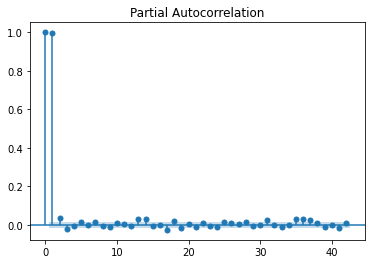

In [13]:
plot_pacf(residuals)
plt.show()

## Fit a Differenced Linear Regression

Knowing that the dataset is not stationary, we can take difference and fit the linear regression again

In [14]:
# Difference the data
df_diff = df.diff().iloc[5:]

# Create the linear model and return metrics/residuals
lmod_diff = LinearRegression(fit_intercept=False)
lmod_diff.fit(df_diff[['WGS5YR']], df_diff[['WGS10YR']])
print('coef: {} intercept: {}'.format( lmod_diff.coef_, lmod_diff.intercept_))
print('rsqr: {}'.format( lmod_diff.score(df_diff[['WGS5YR']], df_diff[['WGS10YR']])))
residuals_diff = lmod_diff.predict(df_diff[['WGS5YR']]) - df_diff[['WGS10YR']]

coef: [[0.84677358]] intercept: 0.0
rsqr: 0.8551942446017223


<AxesSubplot:>

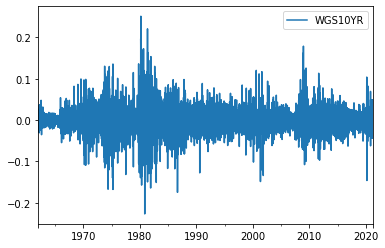

In [15]:
residuals_diff.plot()

# Plot Residuals Differenced

[]

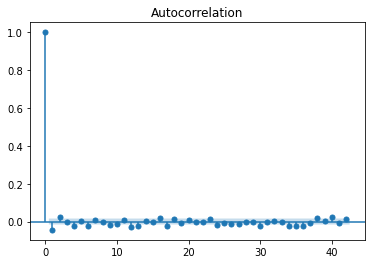

In [16]:
plot_acf(residuals_diff)
plt.plot()

[]

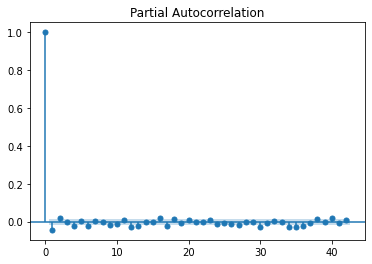

In [17]:
plot_pacf(residuals_diff)
plt.plot()

# Ljung Box of Differenced Residuals

In [18]:
sm.stats.acorr_ljungbox(residuals_diff, lags=[12], return_df=True)

,lb_stat,lb_pvalue
12,78.413092,8.278174e-12


#### What do we think about these residuals vs the first, non-differenced model?

# Fit MA model on residuals_diff

In [19]:
residuals_diff['WGS10YR']

1962-01-09   -0.003065
1962-01-10   -0.011532
1962-01-11   -0.010000
1962-01-12    0.008468
1962-01-15   -0.011532
                ...   
2021-04-26    0.016935
2021-04-27   -0.024597
2021-04-28   -0.016935
2021-04-29   -0.020000
2021-04-30    0.000000
Name: WGS10YR, Length: 15474, dtype: float64

In [20]:
from sktime.forecasting.arima import ARIMA
ma_model = ARIMA(order=(0,0,1))
ma_model.fit(residuals_diff['WGS10YR'])

ARIMA(order=(0, 0, 1))

In [21]:
ma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15474
Model:               SARIMAX(0, 0, 1)   Log Likelihood               35625.581
Date:                Tue, 04 May 2021   AIC                         -71245.161
Time:                        07:57:36   BIC                         -71222.220
Sample:                             0   HQIC                        -71237.561
                              - 15474                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.117e-05      0.000     -0.060      0.952      -0.000       0.000
ma.L1         -0.0434      0.005     -9.521      0.000      -0.052      -0.034
sigma2         0.0006      3e-06    195.045      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             40224.42
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Create a forecast model

From this, we can create a model with our linear regression relationship and our MA(1) model to predict the residuals.

In the Engle-Granger Approach, we first created a linear regression, and used ARMA to fit the residuals. The cointegration vector is <1,-0.847>, which is the coefficient from the linear regression.

Noted issues: 
- The residuals were only close to stationary, which violates assumptions in this method
- The model chose 10Y as the dependent variable, with domain knowledge of yield curve trading you could argue that 5Y is dependent on 10Y yields

### Creating a function to test cointegration using the Engle-Granger approach

Here we look to find significance at multiple levels 

In [22]:
def test_cointegration(X, y):
    lmod = LinearRegression()
    if isinstance(X, pd.Series):
        X = pd.DataFrame(X)

    lmod.fit(X, y)
    yhat = lmod.predict(X)
    residuals = yhat - y

    adfuller_results = sm.tsa.adfuller( residuals, maxlag=1 )
    param_value = adfuller_results[0]
    adfuller_percent_critical_values =  adfuller_results[4]

    found=False
    for k, v in adfuller_percent_critical_values.items():
        param_value = round( param_value, 3)
        if param_value<=v:
            print(f'cointegration at the {k} level of significance. Critical value of: {param_value}')
            found = True
            break

    if not found:
        print('did not find cointegration')

In [23]:
test_cointegration(df['WGS5YR'], df['WGS10YR'])

cointegration at the 1% level of significance. Critical value of: -4.358


# Examine using Johansen's method

We now explore the same data using Johansen's method in statsmodels. This method assesses the validity of a cointegrating relationship using a maximum likelihood estimates approach. There are two types of Johansen's test:

- Trace - linear algebra method to sum eigenvalues
- Maximum eigenvalue approach

Statistical tests to see if there are cointegrating equations

In [24]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

For simplicity, we can reduce the number of observations to the last 1,000

In [25]:
coint_johansen_results = coint_johansen(df.iloc[-1000:],0,2)

Once we run the test, we can pull all the metrics from our results

In [26]:
# Eigenvalues of the coefficient matrix
pd.Series( coint_johansen_results.eig )

0    0.008587
1    0.001654
dtype: float64

In [27]:
# Order of eigenvalues
coint_johansen_results.ind

array([0, 1], dtype=int64)

In [28]:
# Trace statistic
coint_johansen_results.lr1

array([10.24863962,  1.65042203])

In [29]:
coint_johansen_results.lr2

array([8.59821759, 1.65042203])

#### Critical values 
These are in percentages and compare at the three significance levels
If the test statistic is greater than the corresponding critical values, then the null hypothesis (no cointegration) is rejected. 

In [34]:
# Maximum eigenvalue statistic
coint_johansen_results.max_eig_stat

array([8.59821759, 1.65042203])

In [35]:
# Critical values (90%,95%,99%) of the maximum eigenvalue statistic
coint_johansen_results.cvm

array([[12.2971, 14.2639, 18.52  ],
       [ 2.7055,  3.8415,  6.6349]])

In [36]:
# Trace statistic
coint_johansen_results.trace_stat

array([10.24863962,  1.65042203])

In [37]:
# Critical values (90%,95%,99%) of the trace statistic
coint_johansen_results.cvt

array([[13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

### Predicting with cointegration model
We can move forward to create a forecasting model, now that we have identified a VAR(1) model and the coefficients that are required

## Summary of Cointegration

Cointegration looks to model 2 or more times series. It looks to define a long term relationship, using this relationship, we can forecast future values and measure/compare/trade off of short term disequilibrium.

- Engle-Granger approach can only model 2 time series and needs to have dependent/independent time series identified.
- Johansen's method can handle more than 2 time series, treats every test variable as endogenous variables.

Typically, these mehtods have their own strengths and pitfalls. Recommendation is to use both tests.